# Churn Prediction for Direct Debit 

The task is to create a model that predicts which companies are likely to churn at the start of 2015, given a dataset of 2014. The dataset contains the following columns:

- `company_id` : anonymised unique ID for each company
- `vertical`: a category that indicates the industry this company is part of
- `incorporation_date`: date (YYYY-MM-DD) when this company has been set up
- `2014-MM-01_payments`: aggregated count of payments for each company in the
specified month (MM)
- `2014-MM-01_mandates`: aggregated count of unique mandates for each
company in the specified month (MM). A mandate is an authorisation that allows a company to collect Direct Debit payments from a given customer (not every mandate has been used to collect payments)

# Outline

This notebook presents the following outline:

1) **[Data quality checks](#Data-Quality-checks)** 

2) **[Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-%28EDA%29 )** 

* Payments and Mandates
* Relationships wrt to time
* Segmentations by vertical

3) **[Churn Model](#Churn-Model)**

* [Challenges](#Challenges)
    * Nature of churn
    * Data related
    * Choosing a model

* [Survival Analysis](#Survival-Analysis)
    * Kaplan-Meier model
        * Calculating Duration
        * Visualisation of churn
        * Train-test spli
        * KM curves by vertical
        * Statistical Significance
        * Prioritising at-risk customers
        
        
4) **[Ideas for Future Work](#Ideas-for-Future-work)**


In [8]:
# Plotting imports

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

_ = sns.set(style="whitegrid", rc={"figure.figsize": (12, 6),
#                                "legend.fontsize": "large",
                               "axes.titlesize": "large",
                               "xtick.labelsize": "large",
                               "ytick.labelsize": "large",
                               })

In [2]:
from survival_analysis import *

In [3]:
df = get_data()
df.head()

,company_id,2014-01-01_payments,2014-02-01_payments,2014-03-01_payments,2014-04-01_payments,2014-05-01_payments,2014-06-01_payments,2014-07-01_payments,2014-08-01_payments,2014-09-01_payments,...,2014-05-01_mandates,2014-06-01_mandates,2014-07-01_mandates,2014-08-01_mandates,2014-09-01_mandates,2014-10-01_mandates,2014-11-01_mandates,2014-12-01_mandates,vertical,incorporation_date
0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gym/fitness,2013-05-30
1,2,1.0,1.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,gym/fitness,2003-09-25
2,3,6.0,6.0,6.0,6.0,6.0,7.0,8.0,7.0,8.0,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,freelance developer,2008-10-22
3,4,8.0,4.0,7.0,7.0,1.0,2.0,2.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,gym/fitness,2005-06-28
4,5,0.0,0.0,39.0,0.0,54.0,0.0,0.0,22.0,0.0,...,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,accountancy,2013-09-18


# Data Quality checks

Some very basic checks; in practice this part should be more thorough!

In [174]:
# Check for missing values across columns
df.isnull().sum()

company_id             0
2014-01-01_payments    0
2014-02-01_payments    0
2014-03-01_payments    0
2014-04-01_payments    0
2014-05-01_payments    0
2014-06-01_payments    0
2014-07-01_payments    0
2014-08-01_payments    0
2014-09-01_payments    0
2014-10-01_payments    0
2014-11-01_payments    0
2014-12-01_payments    0
2014-01-01_mandates    0
2014-02-01_mandates    0
2014-03-01_mandates    0
2014-04-01_mandates    0
2014-05-01_mandates    0
2014-06-01_mandates    0
2014-07-01_mandates    0
2014-08-01_mandates    0
2014-09-01_mandates    0
2014-10-01_mandates    0
2014-11-01_mandates    0
2014-12-01_mandates    0
vertical               0
incorporation_date     0
dtype: int64

Nice to see no missing values :)

In [183]:
# Check for duplicates
df['company_id'].duplicated().sum()

0

No duplicates either

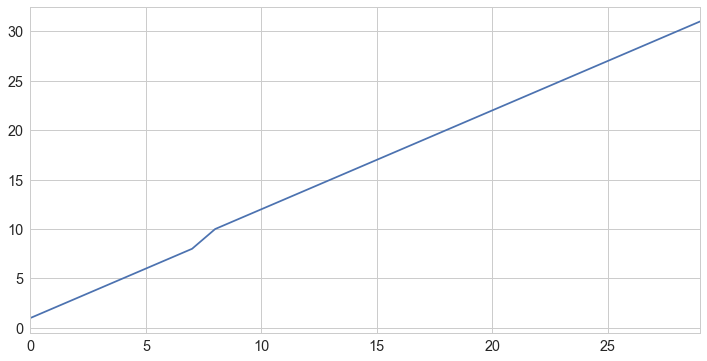

In [185]:
# Check company_id is continuous
df['company_id'].head(30).plot()

Some filtering seems to be present on the `company_id`

# Exploratory Data Analysis (EDA)

* For now we use the full dataset to do the exploration of this dataset, however under real conditions this should be done only on the train set

## Payments and Mandates

Let's look at the relationship between payments and mandates for a sample of companies

In [4]:
# Define payments and mandates columns
cols_payments = [x for x in df if 'payments' in x]
cols_mandates = [x for x in df if 'mandates' in x]

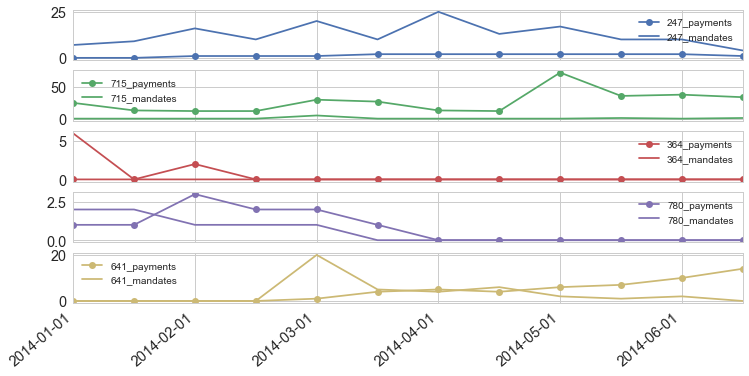

In [9]:
# Explore their relationship for a sample of companies
temp = df.sample(5, random_state=0)
payments = temp[cols_payments].T
payments.columns = [str(x) + '_payments' for x in payments.columns]
mandates = temp[cols_mandates].T
mandates.columns = [str(x) + '_mandates' for x in mandates.columns]
ax = payments.plot(subplots=True, sharex=True, marker='o')
ax = mandates.plot(subplots=True, ax=ax, rot=40)
xticklabels = [x.split('_')[0] for x in cols_payments]
_ = ax[-1].set_xticklabels(xticklabels)

* Mandates can be non-zero even when payments are zero
* In the case of company 247 for example, where payments were always zero while mandates non-zero, could this be an indication of fraud?


#### Aggregation over all companies per month

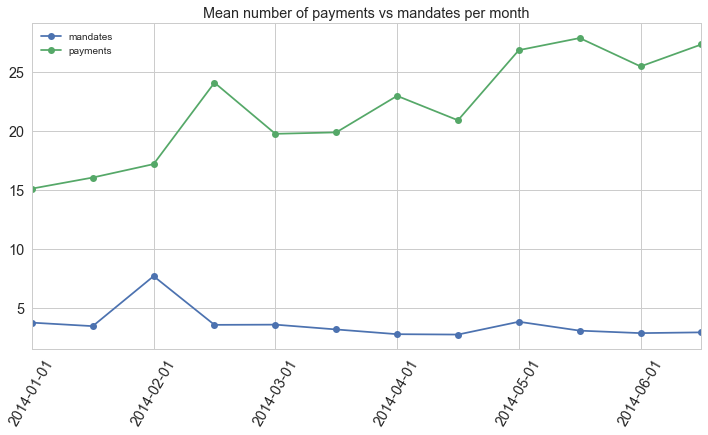

In [213]:
# Get mean number of payments vs mandates per month
mandates = df[cols_mandates].T
mandates.mean(axis=1).plot(rot=60, label='mandates', marker='o')
payments = df[cols_payments].T
ax = payments.mean(axis=1).plot(rot=60, label='payments', marker='o')
ax.set_xticklabels(xticklabels)
plt.legend()
plt.title('Mean number of payments vs mandates per month')

In [223]:
# Get descriptive stats for payments
df[cols_payments].describe()

,2014-01-01_payments,2014-02-01_payments,2014-03-01_payments,2014-04-01_payments,2014-05-01_payments,2014-06-01_payments,2014-07-01_payments,2014-08-01_payments,2014-09-01_payments,2014-10-01_payments,2014-11-01_payments,2014-12-01_payments
count,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000
mean,15.097561,16.037694,17.176275,24.080931,19.745011,19.865854,22.962306,20.892461,26.838137,27.863636,25.458980,27.323725
std,64.310562,62.706482,70.075550,115.130265,68.920850,73.631569,87.531283,84.468913,96.521500,105.180086,99.606663,113.165793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,2.000000,3.000000,3.000000,2.000000,2.000000,2.000000,4.000000,3.000000,2.000000,2.000000
75%,8.000000,10.000000,11.000000,13.000000,13.000000,12.000000,14.000000,12.000000,16.000000,16.000000,14.000000,15.750000
max,1240.000000,1164.000000,1327.000000,2549.000000,1178.000000,1184.000000,1291.000000,1345.000000,1399.000000,1505.000000,1680.000000,1764.000000


* Payments seem to have increased over 2014 i.e. there's an upwards trend
* Mandates on the other hand have kept pretty static and are average lower than payments accross all companies
* The spread of number of payments (std dev) also has increased
* There seems to be some **outliers** in the distribution telling from the 75% quantile vs the max - these should have been investigated and removed if applicable, but due to short time we ignored them...
* Hard to infer any correlation between mandates and payments given this sample

#### Total payments per company

In [226]:
temp = df.copy()
temp['total_payments'] = temp[cols_payments].sum(axis=1)

In [227]:
temp['total_payments'].describe()

count      902.000000
mean       263.342572
std        944.140773
min          1.000000
25%         12.000000
50%         41.000000
75%        155.500000
max      14380.000000
Name: total_payments, dtype: float64

* 75% of companies had less than 155 payments in 2014
* There seems to be some large tails in the data, which can be see in the histogram below (one company had a max of 14,380 total payments). Let's investigate this

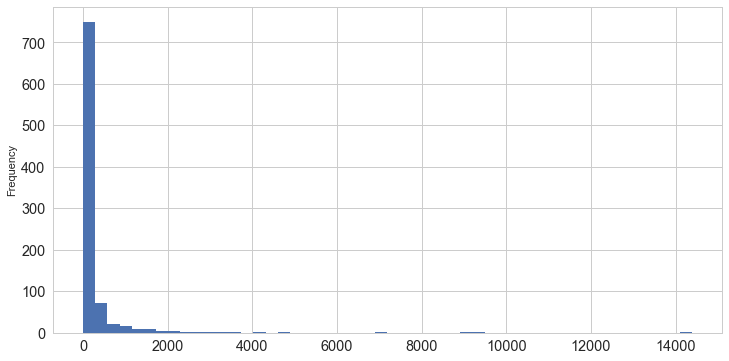

In [228]:
temp['total_payments'].plot(kind='hist', bins=50)

In [231]:
df[temp['total_payments'] == temp['total_payments'].max()][cols_chars + cols_payments]

,company_id,vertical,incorporation_date,2014-01-01_payments,2014-02-01_payments,2014-03-01_payments,2014-04-01_payments,2014-05-01_payments,2014-06-01_payments,2014-07-01_payments,2014-08-01_payments,2014-09-01_payments,2014-10-01_payments,2014-11-01_payments,2014-12-01_payments
415,456,gym/fitness,2007-09-24,876.0,870.0,1044.0,1096.0,1178.0,1168.0,1257.0,1214.0,1353.0,1431.0,1385.0,1508.0


* Seems be a genuine entry, not a data problem

## Relationships wrt to time

<span style="color:red">WARNING: as this is only a subset of data, not necessarily sorted by `incorporation_date`, the below observations in this section could be biased! The below was just intended as a demonstration of the type of analysis I would do given the adequate dataset</span>


#### Payments

Let's first look across all companies, how the payments evolve with time - this could be interprete as the average GC revenue over time (assuming GC revenue is proportional to number of payments processed)

In [218]:
temp.index = temp['incorporation_date']
temp[['total_payments']].head()

,total_payments
incorporation_date,
2013-05-30,2.0
2003-09-25,23.0
2008-10-22,86.0
2005-06-28,57.0
2013-09-18,115.0


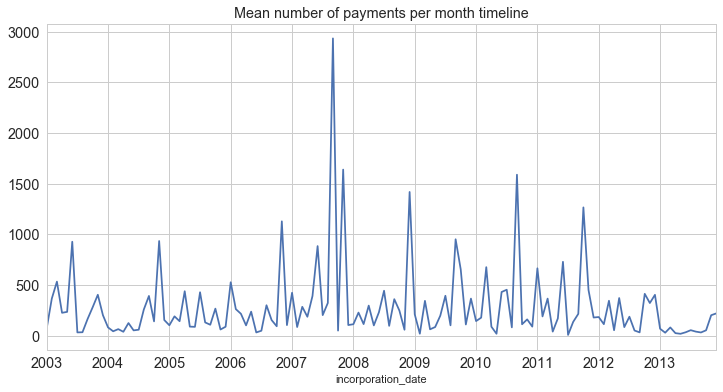

In [156]:
temp['total_payments'].resample('M').mean().plot()
plt.title('Mean number of payments per month timeline')

* Only seasonal pattern observed; no clear growth/decline observed

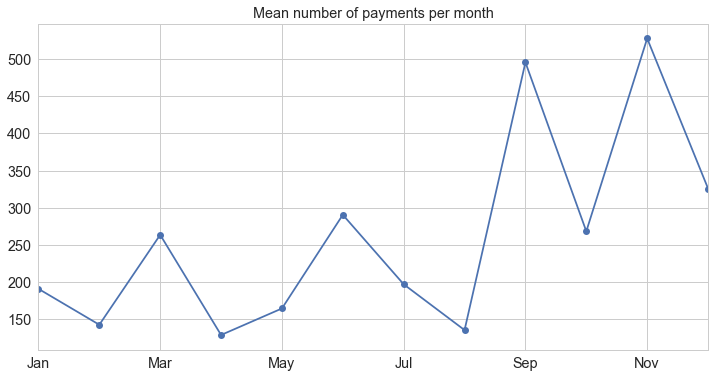

In [157]:
# Mean number of payments per month
monthly = temp['total_payments'].groupby(temp.index.month).mean()
monthly.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly.plot(marker='o')
plt.title('Mean number of payments per month')

* Seems payments do tend to increase during Sep and Nov (bi-modal dist.)

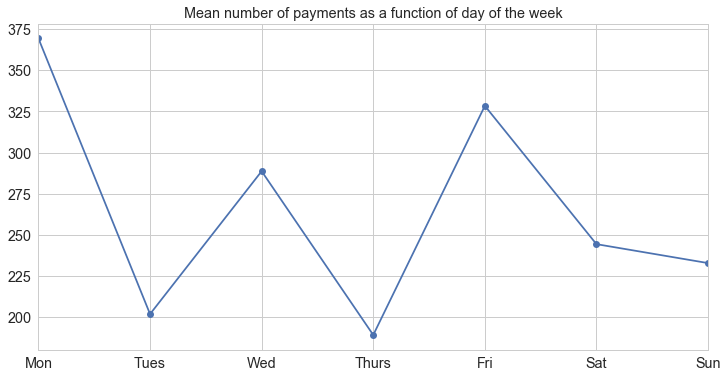

In [219]:
# Mean number of payments per week
weekly = temp['total_payments'].groupby(temp.index.dayofweek).mean()
weekly.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
weekly.plot(marker='o')
plt.title('Mean number of payments as a function of day of the week')

* Similarly, see peaks in mean no. of payments on Mondays and Fridays

#### New users

How about growth in terms of number of newly incorporated companies?

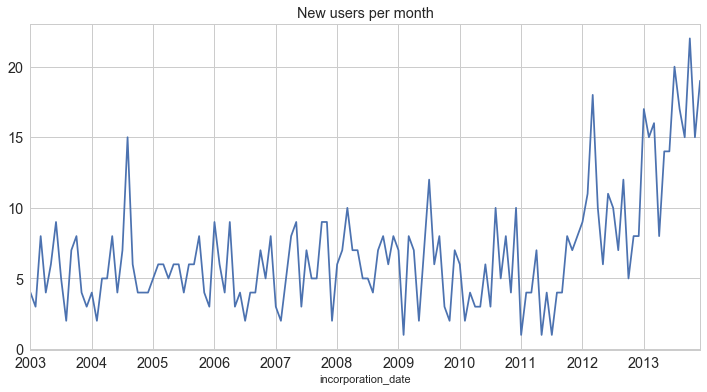

In [169]:
monthly = temp['company_id'].resample('M').count()
monthly.plot()
plt.title('New users per month')

* Here we do see an upwards trend starting in 2011

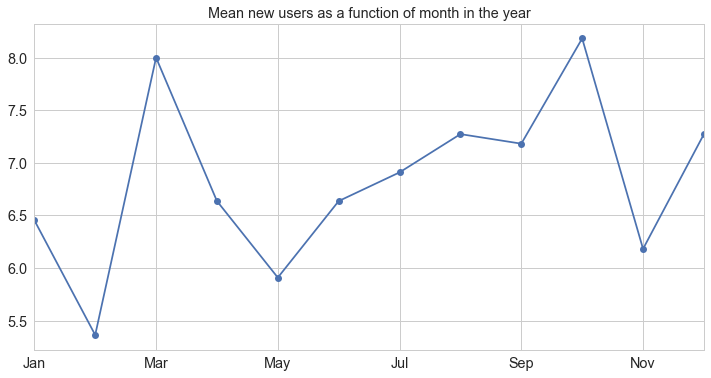

In [216]:
# Total new users over the months
monthly2 = monthly.groupby(monthly.index.month).mean()
monthly2.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly2.plot(marker='o')
plt.title('Mean new users as a function of month in the year')

* Seems new users peak in March and October - could this be because of e.g. a promotion/campaign?

## Segmentations by vertical

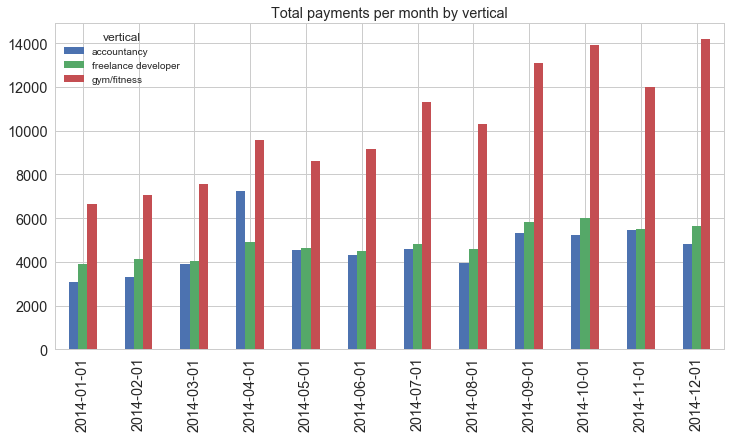

In [252]:
grouped = df.groupby('vertical')
temp = grouped[cols_payments].sum().T
ax = temp.plot(kind='bar')
_ = ax.set_xticklabels(xticklabels)
plt.title('Total payments per month by vertical')

* Gym/fitness vertical registers highest share and growth. Other two verticals register little growth and in terms of share seem very similar
* Spike in accountancy in April could be due to end/start of new tax year?

In [253]:
df['total_payments'] = df[cols_payments].sum(axis=1)

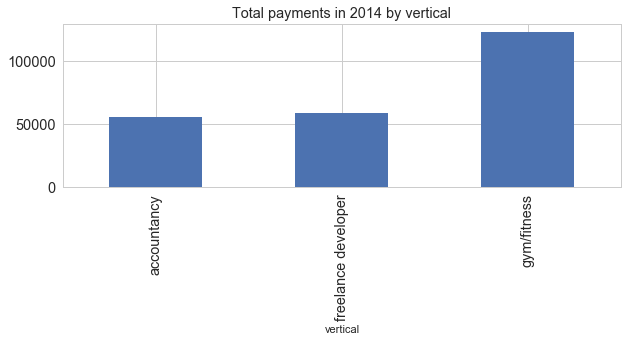

In [262]:
temp = grouped['total_payments'].sum()
temp.plot(kind='bar', figsize=(10, 3))
plt.title('Total payments in 2014 by vertical')

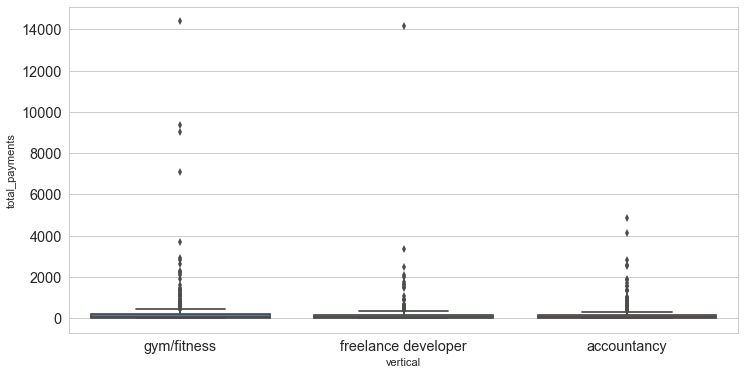

In [281]:
sns.boxplot(x='vertical', y='total_payments', data=df)

* This box plot shows that for all verticals the distributions are right-skewed and suffer from quite a few **outliers** (in fact box plot is hardly visible as most of the mass of the distribution is within less than 155, as we saw earlier. As mentioned earlier, these should have been investigated and removed if applicable but here we didn't 

# Churn Model


## Challenges

The following are typical challenges in churn models:

### Nature of churn

* **Defining the churn event** - for non-subscription based businesses there is no clear way to know when they have churned or not. Typically simple assumptions are made about this, e.g. if a user hasn't used the servce for $n$ periods of time, then it has churned - however this fails in cases when customers have different seasonalities or burst-like behaviour
* **Churn event censorship:** customers that are considered non-churners up to the point when the model is trained are said to be 'right-censored' as they were only partially observed. The churn event censorship is problematic for conventional supervised machine learning methods that require dataset labels to be fully observable. The **survival models** are therefore an attractive alternative
* **Type of churn** - for example this could be voluntary or involuntary, e.g. involuntary churners could be from terminations by the company due to fraudulent activity, or for other reasons independent of the company. Hence, having a separate model for each churn type is typically better
* **Churn rate** - as the customer base size changes this also changes
* **Changes in behaviour** - a model could cease to perform in the future due to changes in customer behaviour

### Data related

* **Low churn rate (class imbalance):** churn is normally a rare event presuming the business is in a good shape. This leads to 'class imbalance' where the number of churners is much smaller than non-churners, so the model performs poorly. There are a number of approaches to alleviate class imbalance, e.g. down/up sampling

### Choosing a model


* **Binary classification:** Although quite commonly used, this approach ignores churn event censorship and is sensitive to class imabalance, unless handled properly, so it makes it and inferior choice vs survival analysis


* **Survival analysis:** these are the peferred choice when modelling time to event datasets. They do not label customers as churner and non-churners. Instead they provide a survival curve, which can be used to compute the expected time to churn event for each customer. 
Accordingly, a customer can be regarded as churner if their predicted time to churn is close (based on a preset threshold) to their current length of tenure. 
The are a few model options in this space:
    * **Kaplan-Meier (KM)** - this is the simplest model as it is non-parametric. Given the duration until the churn event (or censorship) for a set of customers, it provides the `Survival Function`, i.e. their probability of survival over time
    * **Survival regression** - take the KM idea to the next level by incorporating additional features (covariates) in the modelling process. There are variations of this based on how the covariates are related to the survival curve. Popular choices are the Cox and Aalen model.
    

## Survival Analysis


Based on the above points, our choice will be a **Survival Analysis** model. First we will try the simplest, which is the **Kaplan-Meier** model. If time allows, we will then try the Survival regression.


Most of the code used here can be found in the script `survival_analysis.py`, where we used the  python library `lifelines` - see more info on this here http://lifelines.readthedocs.io/en/latest/Quickstart.html


NOTE: for simplicity we ignore for now all the `mandates` data

## Kaplan-Meier model

This model requires two input features:
* Duration `T`: the time to the churn event, i.e. how long the customers had been on your service
* Event status `E`: indicates whether the event (churn) has occured to each customer or not, or whether it has been censored

### Calculating Duration

We want to make inferences about duration, and it is likely that not all churn events have occured yet. We therefore need to define the **criteria** for what we call a 'customer has churned'. This is the most critical input, for which I explored a few different options:

* **Start date:** as the "birth date" I am using the `incorporation_date` found in the data, assuming none of the customers churned before 2014 as can be inferred as follows:

In [284]:
df[df['total_payments'] == 0].shape

(0, 28)

* **End date:** as the "death date" I tried two different definitions - a simple one and another one to try to capture the difference in seasonality between customers: 
    
    1. If payments stopped for at least 3 months after the last recorded payment, we consider this customer churned 
    ```python
    def get_death_time_v1(x):
    end_time = None
    dead = False
    for i, p in enumerate(x):
        if not dead:
            end_time = x.index[i]
        # Require at least 3 months of no activity
        if x[i] == 0 and x[i - 1] == 0 and x[i - 2] == 0:
            dead = True
            # print('dead:', x.index[i], p)
        else:
            dead = False
    if end_time and dead:
        return pd.to_datetime(end_time.split('_')[0])
    return np.nan
    ```
    
    2. We categorise customers by payment frequency - some have monthly payments (e.g. gym membership), some quarterly (e.g. utility bills). If a customer has got zero payments for at least 2 payments cycles we consider this customer as churned
    
    ```python
def get_death_time_v2(x):
    # In how many months do we have payment activity?
    active_months = len(x[(x > 0)])

    # remove the number of trailing '0' payment months
    length = len(x)
    add = True
    counter = 0
    for i in range(0, length):
        i += 1
        if x[-i] == 0:
            if add:
                counter += 1
        else:
            add = False
    if counter > 0:
        y = x[:-counter]
    else:
        y = x
    removed_trailing_months = len(y)

    # Calculate the average payment frequency observed, ignoring any recent '0' payment months
    frequency = int(removed_trailing_months / active_months)

    # As dead time threshold I set 2*frequency.
    # So if a customer did not have any payments for twice his usual payment frequency
    # I consider that customer churned.
    dead_time = 2 * frequency

    # Extract deadtime if it exists:
    end_time = None
    dead = False
    z = x[int(removed_trailing_months):int(removed_trailing_months + dead_time)]

    if len(z) > 0:
        if len(z[z == 0.0]) == dead_time:
            end_time = x.index[removed_trailing_months]
            dead = True
    if end_time and dead:
        return pd.to_datetime(end_time.split('_')[0])
    return np.nan
    ```

Let's look at an example for a particular 'company_id=5'

In [5]:
x = df.loc[4, cols_payments]
x

2014-01-01_payments     0
2014-02-01_payments     0
2014-03-01_payments    39
2014-04-01_payments     0
2014-05-01_payments    54
2014-06-01_payments     0
2014-07-01_payments     0
2014-08-01_payments    22
2014-09-01_payments     0
2014-10-01_payments     0
2014-11-01_payments     0
2014-12-01_payments     0
Name: 4, dtype: object

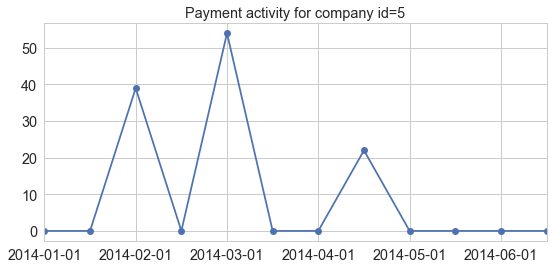

In [10]:
ax = x.plot(marker='o', figsize=(9, 4))
_ = ax.set_xticklabels(xticklabels)
_ = plt.title('Payment activity for company id=5')

This company looks like it has churned under definition 1, but not under def 2:

In [16]:
print('In v1 this customer churned on {}'.format(get_death_time_v1(x)))

In v1 this customer churned on 2014-11-01 00:00:00


In [48]:
print('In v2 this customer churned on {}'.format(get_death_time_v2(x)))

In v2 this customer churned on 2014-09-01 00:00:00


With this, we proceed to calculate the duration `T` (in months) and churn event `E` using `v1` above and the `lifelines.utils.datetimes_to_durations` helper:

In [344]:
from lifelines.utils import datetimes_to_durations

# Calculate the death date over all rows using lambda function
df['death_date'] = df[cols_payments].apply(lambda x: get_death_time_v1(x), axis=1)

# Create duration and churn status
start_times = df['incorporation_date']
end_times = df['death_date']
obs_time = datetime.datetime(2015, 1, 1)
T, E = datetimes_to_durations(start_times, end_times, freq='M', fill_date=obs_time)
df['T'] = T  # duration (in months)
df['E'] = E  # churn status

### Visualisation of churn

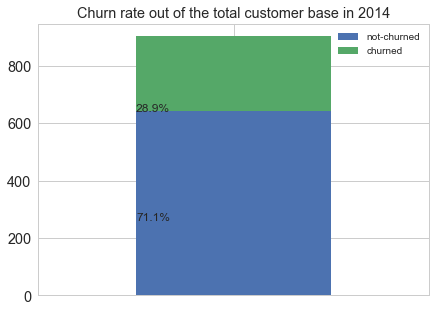

In [466]:
temp = df[['company_id', 'E']].groupby('E').count()
ax = temp.T.plot.bar(stacked=True, figsize=(7, 5))
_ = ax.set_xticklabels([])
plt.legend(['not-churned', 'churned'])

heights = {'71': 261, '28': 641}  # fix as labels seems wrongly switched
for p in ax.patches:
    p_height = p.get_height()
    pct = (p_height / df.shape[0]) * 100
    #ax.annotate('{:.1f}%'.format(pct), (p.get_x(), p_height))
    ax.annotate('{:.1f}%'.format(pct), (p.get_x(), heights[str(int(pct))]))
    
_ = plt.title('Churn rate out of the total customer base in 2014')

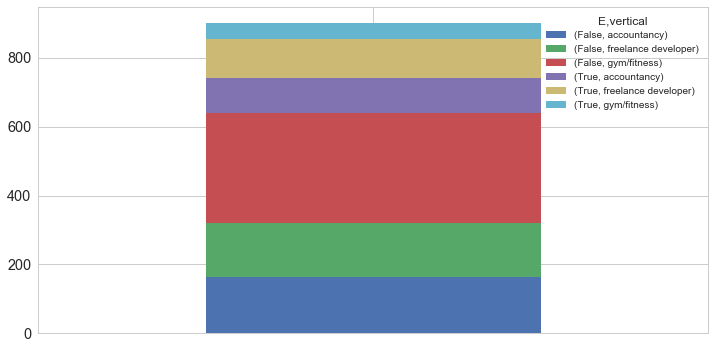

In [467]:
temp = df[['company_id', 'E', 'vertical']].groupby(['E', 'vertical']).count()
temp = temp.T

ax = temp.plot.bar(stacked=True)
_ = ax.set_xticklabels([])


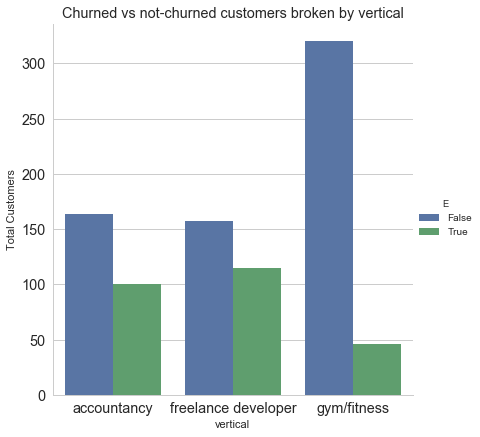

In [453]:
temp = df[['company_id', 'E', 'vertical']].groupby(['vertical', 'E']).count().reset_index()
temp = temp.rename(columns={'company_id': 'Total Customers'})
g = sns.factorplot(x="vertical", y="Total Customers", hue="E", data=temp, size=6, kind="bar")
_ = plt.title('Churned vs not-churned customers broken by vertical')

From the above plots we see:

* We have about 30% churn rate in the 2014 customer base (this indicates class imbalance wrt the total, as expected and discussed before)
* In the stacked bar we see the largest base is from gym/fitness vertical, while accountancy and freelance developers are about half of the gym base, and both are relatively equal in terms shares
* Despite gyms being the largest base, the biggest churners are accountancy and freelance developers
* Accountancy and Freelance developers have quite a rather concerning churn rate as for both this is above 50%, and more accute in freelance developers. Gym/fitness has a more 'normal' churn rate

### Train-test split

<span style="color:red">In real circumstance at this point one would proceed to split the data into train and test samples (or better: a train-validation-test split) to be able to assess model performance. However, given that here we are not using a Binary classifier and time constrains we will not do this here and just take the KM fit in the entire data. Below we outline some steps one would take to split into train and test: </span>

In [490]:
df.shape

(902, 31)

In [483]:
# Do an 80-20 split by taking the first 80% of the rows 
# (ideally better to randomly sample in case sorting applied in data)
train_size = int(df.shape[0] * 0.8)
train_size

721

In [486]:
train = df.iloc[:train_size, :]

Now one would check the train dataset has good class and segmentation balance in the train sample

In [487]:
train[['company_id', 'E']].groupby('E').count()

,company_id
E,
False,510
True,211


This train set has a similar class balance to the original dataset, so good

In [488]:
train[['company_id', 'vertical']].groupby('vertical').count()

,company_id
vertical,
accountancy,219
freelance developer,216
gym/fitness,286


Also has good balance across the vertical segmentation, so good

In [489]:
train[['company_id', 'vertical', 'E']].groupby(['vertical', 'E']).count()

company_id
vertical            E                
accountancy         False         139
                    True           80
freelance developer False         124
                    True           92
gym/fitness         False         247
                    True           39

The churn rates are also similar to the full dataset, so in theory we could use this

### Now back to the KM model

Using still the `v1` churn definition, we get the following KM Survival Function:

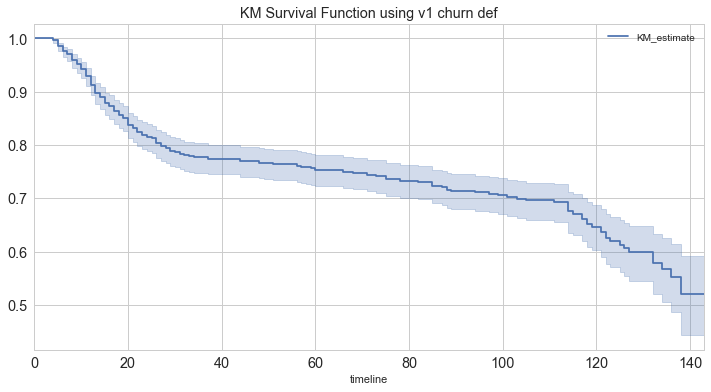

In [471]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succiently, kmf.fit(T, E)
kmf.plot()
plt.title('KM Survival Function using v1 churn def')

This graph tell us the probability of a customer still being a customer (y-axis) after n months (x-axis). 

And this is how `v1` compares to `v2` churn definition:

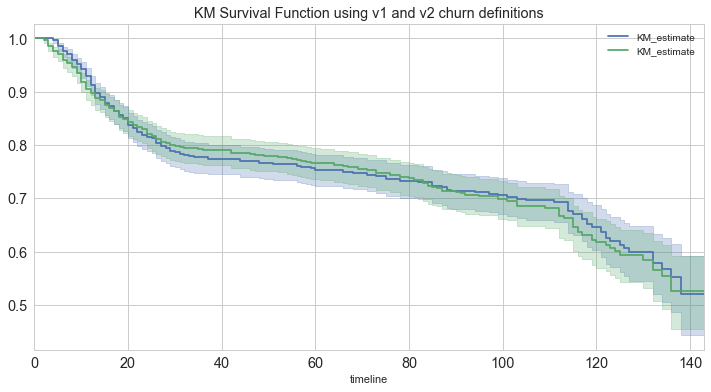

In [53]:
run_two_churn_defs(df)
plt.title('KM Survival Function using v1 and v2 churn definitions')

As these two curves are not very different given their uncertainty bands, we will limit the results to just v1 definition which is easier to understand and simpler in terms of coding.

### KM curves by vertical

Can create different KM curves for each subset of subscribers you want to look at.  The statistical significance of the differences can be tested in many ways, including the Log-Rank test, which we’ll apply below. The Log-Rank test simply evaluates whether the underlying population survival curves for the two sampled groups are likely to be the same. The p-value is essentially the probability that the curves are the same.

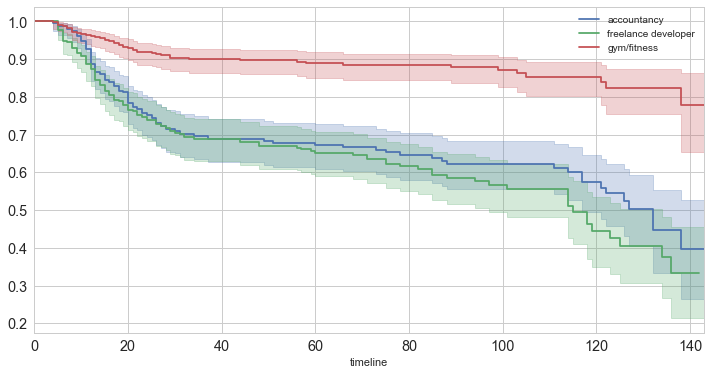

In [598]:
# Fit a separate KM model to each vertical
vertical_types = np.unique(df['vertical'])

# Store results in this dict
kmf_dict = {}
mask_dict = {}

for i, _type in enumerate(vertical_types):
    mask = (df['vertical'] == _type)
    kmf.fit(T[mask], E[mask], label=_type)
    # if model not yet in dict, add it
    if _type not in kmf_dict:
        kmf_dict[_type] = kmf
    if _type not in mask_dict:
        mask_dict[_type] = mask        
    if i == 0:
        ax = kmf.plot()
    else:
        kmf.plot(ax=ax)


* Both accountancy and freelance developer seem to have very similar churn profiles
* Most interesting is the separation of verticals between gym/fitness and the rest (accountancy + freelance developer)
* This tells that gym membership direct debit payments are very regular with significant higher chance of retention
* In the 3 cases we see large uncertainty bands surrounding the profile, given the small dataset and large censorship

#### Statistical significance of the different curves

In [599]:
mask_dict.keys()

dict_keys(['accountancy', 'freelance developer', 'gym/fitness'])

In [606]:
from lifelines.statistics import logrank_test

for _type in mask_dict:
    mask = mask_dict[_type]
    results = logrank_test(T[mask], T[~mask], E[mask], E[~mask], alpha=.99)
    print('#########   Results for {}   #########'.format(_type))
    print(results.print_summary())

#########   Results for accountancy   #########

t_0=-1, alpha=0.99, null_distribution=chi squared, df=1

test_statistic      p     
       13.3654 0.0003  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
None
#########   Results for freelance developer   #########

t_0=-1, alpha=0.99, null_distribution=chi squared, df=1

test_statistic      p     
       35.2654 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
None
#########   Results for gym/fitness   #########

t_0=-1, alpha=0.99, null_distribution=chi squared, df=1

test_statistic      p     
       75.0904 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
None


They all seem to be significant...

### Prioritising at-risk customers

So we have 3 models for each of the verticals:

In [509]:
kmf_dict

{'accountancy': <lifelines.KaplanMeierFitter: fitted with 366 observations, 320 censored>,
 'freelance developer': <lifelines.KaplanMeierFitter: fitted with 366 observations, 320 censored>,
 'gym/fitness': <lifelines.KaplanMeierFitter: fitted with 366 observations, 320 censored>}

Let's estimate the churn probabilities for each of the verticals then:

In [561]:
# Estimate the churn probabilities for each of the verticals
df['churn_prob'] = np.nan
for i, _type in enumerate(vertical_types):
    print('Estimating {} probabilities...'.format(_type))
    mask = (df['vertical'] == _type)
    # Use lambda function to loop over all durations and apply the correct KM curve
    # Note churn prob is 1 - survival prob.
    df.loc[mask, 'churn_prob'] = df.loc[mask, 'T'].apply(lambda x: 1 - kmf_dict[_type].predict(x))

Estimating accountancy probabilities...
Estimating freelance developer probabilities...
Estimating gym/fitness probabilities...


Assuming the business model in GC is that customers with the highest number of payments throughout the year, are the most valuable, we can sort by this metric first and then by churn risk from highest to lowest:

In [596]:
# Sorting by value (assuming this is proportional to total payments)
temp = df.sort_values(['vertical', 'total_payments', 'churn_prob'], ascending=[False, False, False])
temp = temp[['company_id', 'vertical', 'total_payments', 'churn_prob']]
temp.groupby('vertical').head(5)

,company_id,vertical,total_payments,churn_prob
415,456,gym/fitness,14380.0,0.115359
831,928,gym/fitness,9363.0,0.115359
795,885,gym/fitness,9040.0,0.099438
47,50,gym/fitness,7069.0,0.221457
837,935,gym/fitness,3675.0,0.099438
261,286,freelance developer,14157.0,0.115359
324,358,freelance developer,3356.0,0.102984
544,603,freelance developer,2492.0,0.038251
770,857,freelance developer,2071.0,0.146201
150,159,freelance developer,1978.0,0.102984


Sorting by highest churn risk gives a different result:

In [597]:
# Sorting by highest churn risk
temp = df.sort_values(['vertical', 'churn_prob', 'total_payments'], ascending=[False, False, False])
temp = temp[['company_id', 'vertical', 'total_payments', 'churn_prob']]
temp.groupby('vertical').head(5)

,company_id,vertical,total_payments,churn_prob
47,50,gym/fitness,7069.0,0.221457
823,920,gym/fitness,2901.0,0.221457
93,97,gym/fitness,616.0,0.221457
283,310,gym/fitness,517.0,0.221457
860,959,gym/fitness,287.0,0.221457
14,16,freelance developer,867.0,0.221457
680,752,freelance developer,621.0,0.221457
312,343,freelance developer,607.0,0.221457
284,311,freelance developer,169.0,0.221457
26,28,freelance developer,57.0,0.221457


Either of these two lists could be used to take actions against churn!

# Ideas for Future work

Due to the short time spent working on this project, the below are left as avenues for future work:

1) Remove **outliers** in the payments and mandates data where applicable and see the effect from this in the current model

2) Extracting **seasonality** using fft (Fast Fourier Transforms) or `statsmodels` `seasonal_decompose`


3) Understand how **mandates** could be incorporated into the model (so far only used payments)


4) KM curves for different duration bins


5) Implement a **Survival Regression model** like the Cox and Aalen model from `lifelines` (see http://lifelines.readthedocs.io/en/latest/Survival%20Regression.html) 


6) Do more **feature engineering** with this data. This would be particularly important for (4). For example using Exponential Moving Averages (EMAs) to give more weights to recent data; and using lagged values from the time series


7) Compare Survival Analysis results with **supervised binary classifier** models


8) Also could try an unsupervised model, like **k-means clustering** to find n=2 clusters, where one cluster would be churned and the other non-churned. This would require a lot of (5)


9) Do a proper train-test split of the data and/or **cross-validation** - this would be particularly importan for (4), (6) and (7)
